In [135]:
import sys
# sys.path.append('../../')

from os import listdir

from hdf5storage import loadmat, savemat 
import numpy as np 
from matplotlib import pyplot as plt

from scipy import signal 
# from hnlpy.timeop import makefiltersos
# from hnlpy.timeop import narrowfilter 
from scipy.signal import sosfiltfilt
from scipy.signal import hilbert
from scipy.signal import savgol_filter
from scipy.stats import sem
from scipy import stats
from scipy.stats import f_oneway
from numpy.polynomial.polynomial import polyfit, polyval
from scipy.stats import pointbiserialr
import networkx as nx
from sklearn.cross_decomposition import PLSCanonical

from scipy.stats import pearsonr


# load fif file
import mne
mne_object=mne.io.read_raw_fif('../Archived/Pcorr_4states_2sestype/chan_locs/TMSi32chan_loc_small.fif')


Opening raw data file ../Archived/Pcorr_4states_2sestype/chan_locs/TMSi32chan_loc_small.fif...
Isotrak not found
    Range : 0 ... 2000 =      0.000 ...     1.000 secs
Ready.


C:\Users\zhouz\AppData\Local\Temp\ipykernel_48032\1408369924.py:29: RuntimeWarning: This filename (../Archived/Pcorr_4states_2sestype/chan_locs/TMSi32chan_loc_small.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_object=mne.io.read_raw_fif('../Archived/Pcorr_4states_2sestype/chan_locs/TMSi32chan_loc_small.fif')


In [61]:
# (Color Scheme) 
red         = [1, 0, 0]
pink        = [1, 0.65, 0.75]
black       = [0, 0, 0]
white       = [1, 1, 1]
blue        = [0, 0, 1]
mediumblue  = [0, 0.4, 0.7]
green       = [0, 1, 0]
darkgreen   = [0, 0.5, 0]
grey        = [0.5, 0.5, 0.5]
yellow      = [1, 1, 0]
deepyellow  = [1, 0.8, 0.2]
gold        = [212/255, 175/255, 55/255]
brown       = [150/255, 75/255, 0]
magenta     = [1, 0, 1] 
cyan        = [0, 1, 1]  
purple      = [0.6, 0.1, 0.9]

# % https://www.mathworks.com/help/matlab/creating_plots/specify-plot-colors.html
matlab_blue     = [0, 0.4470, 0.7410]
matlab_orange   = [0.8500, 0.3250, 0.0980]
matlab_gold     = [0.9290, 0.6940, 0.1250]
matlab_purple   = [0.4940, 0.1840, 0.5560]
matlab_green    = [0.4660, 0.6740, 0.1880]
matlab_cyan     = [0.3010, 0.7450, 0.9330]
matlab_red      = [0.6350, 0.0780, 0.1840]

# combine colors
condicolors = [darkgreen, red, blue, magenta, purple, purple]
dire3colors = [darkgreen, brown, magenta]
syn2colors = [darkgreen, pink]
HNLcolors = [darkgreen, deepyellow, pink]
freq7colors = [black, red, deepyellow, darkgreen, matlab_blue, blue, matlab_purple]

color_4st=[matlab_green,red,blue,black]

In [81]:
# load chan locs for topoplots
dict_loc=loadmat('../Archived/Pcorr_4states_2sestype/chan_locs/xyzlabels.mat')
x=dict_loc['x']
y=dict_loc['y']
z=dict_loc['z']
labels=dict_loc['labels']

# adjust coords for nilearn plots
coords=np.zeros((32,3))
for i in range(32):
    coords[i,:]=[x[i]*700, y[i]*900-15, z[i]*950-15]

#  construct text for networkx labels
labeldict = {}
for i in range(32):
    labeldict[i]=labels[i]

# load pos for networkx plots
pos_mat=loadmat('../Archived/Pcorr_4states_2sestype/chan_locs/pos.mat')
pos=pos_mat['pos']


# construct full edges_list
edges_list=list() # each edge is a two element tuple
for i in range(32):
    for j in range(32):
        if i<j: # use indicies to remove half of edges and colors and the diagonal
            edges_list.append((i,j))

In [4]:
# def matrixplot(data,title):
# 	plt.figure()
# 	plt.imshow(data,vmin =-0.5,vmax = 0.5, cmap = 'jet')
# 	plt.colorbar()
# 	plt.title(title)
# 	plt.xticks(range(32),labels = labels,rotation = 'vertical')
# 	plt.yticks(range(32),labels = labels,rotation = 'horizontal')


In [82]:
# #def generate random graphs 
# def gen_graphs(G):
# 	randG = dict()
# 	for j in range(len(G)):
# 		nnodes = G[j].number_of_nodes
# 		nedges = G[j].number_of_edges
# 		randG[j] = nx.gnm_random_graph(nnodes,nedges)
# 	return randG 
	

Text(0.5, 1.0, 'Ar num of edges 169')

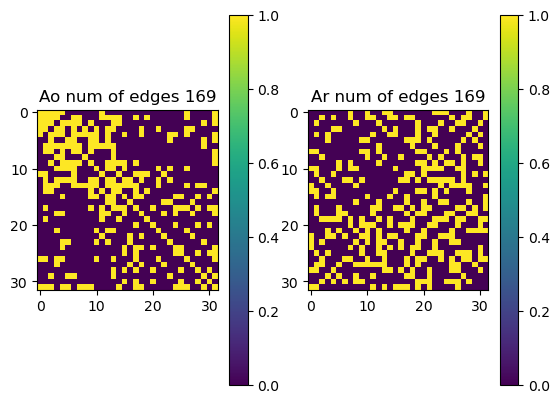

In [112]:
# # Test: Using same number of edge to construct random network and convert into a adjencency matrix
# Ao=A_syn[syn][st][tr,freq,:,:]
# G=nx.from_numpy_array(A_syn[syn][st][tr,freq,:,:])
# nEdges = len(G.edges())
# R=nx.gnm_random_graph(32, nEdges, seed=None, directed=False)
# Ar = nx.adjacency_matrix(R).toarray()
# nEdges_r=len(nx.from_numpy_array(Ar).edges())
# fig,ax=plt.subplots(1,2)
# plt.sca(ax[0]);plt.imshow(Ao);plt.colorbar();plt.title('Ao num of edges '+str(nEdges))
# plt.sca(ax[1]);plt.imshow(Ar);plt.colorbar();plt.title('Ar num of edges '+str(nEdges_r))

In [113]:
# # collect random network correlation for mutual 
# Ar_syn=np.zeros((2,4,36,7,32,32)) # 36 random graph
# for syn in range(2):
#     for st in range(3,4): # only for mutual
#         for tr in range(36):
#             for freq in range(7):
#                 G=nx.from_numpy_array(A_syn[syn][st][tr,freq,:,:])
#                 nEdges = len(G.edges())
#                 R=nx.gnm_random_graph(32, nEdges, seed=None, directed=False)
#                 Ar = nx.adjacency_matrix(R).toarray() # random graph matrix
#                 Ar_syn[syn,st,tr,freq,:,:] = Ar
#                 del(G,R,Ar)
# # 1 s


In [114]:
# # compute correlation
# r_ArH=np.zeros((2,4,7,32,32))
# p_ArH=np.zeros((2,4,7,32,32))
# for syn in range(2):
#     for st in range(3,4):
#         for freq in range(7):
#             for k in range(32):
#                 for l in range(32):
#                     r_ArH[syn,st,freq,k,l], p_ArH[syn,st,freq,k,l]= pointbiserialr(
#                         Ar_syn[syn][st][:,freq,k,l],H_syn[syn][st])

c:\Users\zhouz\mne-python\1.3.1_0\envs\mne\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [115]:
# # repeat the above 2 step 100 times
# r100_ArH=np.zeros((100,2,4,7,32,32)) # Distribution
# for r in range(100):
#     # construct 36 random network with matched number of edges
#     Ar_syn=np.zeros((2,4,36,7,32,32)) # 36 random graph
#     for syn in range(2):
#         for st in range(3,4): # only for mutual
#             for tr in range(36):
#                 for freq in range(7):
#                     G=nx.from_numpy_array(A_syn[syn][st][tr,freq,:,:])
#                     nEdges = len(G.edges())
#                     R=nx.gnm_random_graph(32, nEdges, seed=None, directed=False)
#                     Ar = nx.adjacency_matrix(R).toarray() # random graph matrix
#                     Ar_syn[syn,st,tr,freq,:,:] = Ar
#                     del(G,R,Ar)
#     # compute correlation
#     r_ArH=np.zeros((2,4,7,32,32))
#     p_ArH=np.zeros((2,4,7,32,32))
#     for syn in range(2):
#         for st in range(3,4):
#             for freq in range(7):
#                 for k in range(32):
#                     for l in range(32):
#                         r_ArH[syn,st,freq,k,l], p_ArH[syn,st,freq,k,l]= pointbiserialr(
#                             Ar_syn[syn][st][:,freq,k,l],H_syn[syn][st])
#                 r100_ArH[r,syn,st,freq,:,:]=r_ArH[syn,st,freq,:,:]
# # 18 min


c:\Users\zhouz\mne-python\1.3.1_0\envs\mne\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [116]:
# outdict = dict()
# outdict['r100_ArH']       = r100_ArH
# savemat('r100_ArH',outdict,store_python_metadata = True) 

In [ ]:
outdict=loadmat('r100_ArH.mat')
r100_ArH  = outdict['r100_ArH']

In [129]:
# # z-score estimate
# zscore_AH=np.zeros((2,4,36,7,32,32)) 
# for syn in range(2):
#     for st in range(3,4): # only for mutual
#         for tr in range(36):
#             for freq in range(7):
#                 for i in range(32):
#                     for j in range(32):
#                         r_distri_random=r100_ArH[:,syn,st,freq,i,j]
#                         r_AH_real=r_AH[syn,st,freq,i,j]
#                         r_distri_random=[r_AH_real]+r_distri_random
#                         zscores=stats.zscore(r_distri_random)
#                         zscore_AH[syn,st,tr,freq,i,j]=zscores[0]
# # 44s

In [130]:
# # save 
# outdict =dict()
# outdict['zscore_AH']=zscore_AH
# savemat('zscore_AH',outdict,store_python_metadata=True)

In [ ]:
outdict=loadmat('zscore_AH.mat')
zscore_AH=outdict['zscore_AH']

In [ ]:
st=3
r3_rand=np.zeros((100,3,2,4,7,100,32,32))

Text(0.5, 0.98, 'zscore of the correlation between pcorr and H  Mutual')

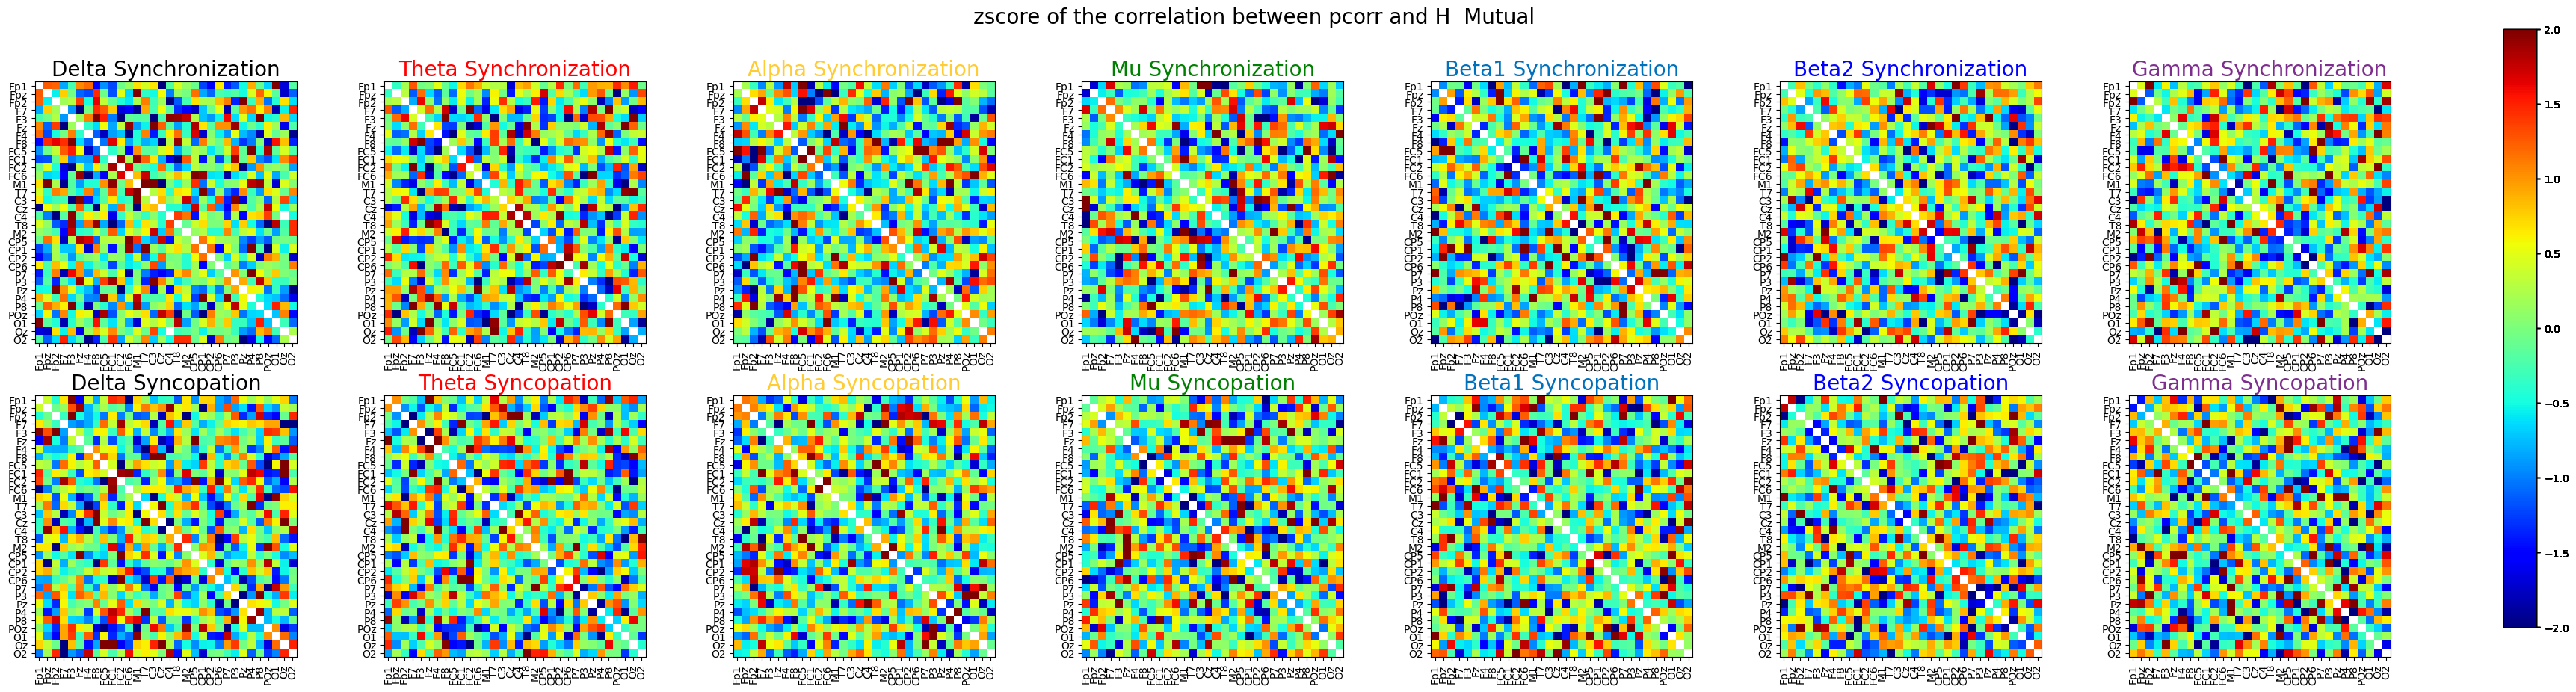

In [145]:
# plot the zscore
st=3 # only look at mutual
fig, ax = plt.subplots(2,7,figsize=(6*7+2, 5*2))
for syn in range(2):
    for freq in range(7):
        plt.sca(ax[syn,freq])
        data = np.mean(zscore_AH[syn,st,:,freq,:,:],axis=0)
        title = band_labels[freq]+' '+ syn2names[syn]

        im=plt.imshow(data,vmin =-2,vmax = 2, cmap = 'jet')
        plt.title(title,color=freq7colors[freq],fontsize=20)
        plt.xticks(range(32),labels = labels,rotation = 'vertical')
        plt.yticks(range(32),labels = labels,rotation = 'horizontal')

        fig.subplots_adjust(right=0.85)
        cbar_ax2 = fig.add_axes([0.88, 0.15, 0.01, 0.8])
        cbar_edges=fig.colorbar(im,cbar_ax2)
        cbar_edges.ax.tick_params(labelsize=10)
        # cbar_edges.set_label('Z-score',fontsize = 20, rotation=90)
        # cbar_edges.ax.yaxis.set_label_position('left')

plt.suptitle('zscore of the correlation between pcorr and H  '+states4names[st],fontsize=20)


In [118]:
# # construct 36 random network with matched number of edges
# cr3_syn=np.zeros((2,4,7,36,3,32)) # 36 random graph
# for syn in range(2):
#     for st in range(3,4): # only for mutual
#         for tr in range(36):
#             for freq in range(7):
#                 G=nx.from_numpy_array(A_syn[syn][st][tr,freq,:,:])
#                 nEdges = len(G.edges())
#                 R=nx.gnm_random_graph(32, nEdges, seed=None, directed=False)
#                 xr=np.zeros((3,32))
#                 for chan in range(32):
#                     xr[0,chan]=nx.clustering(R)[chan]
#                     xr[1,chan]=nx.degree_centrality(R)[chan]
#                     xr[2,chan]=nx.betweenness_centrality(R)[chan]
#                 cr3_syn[syn,st,freq,tr,:,:]=xr
# # 1 m 15s


In [120]:
# # compute correlation
# r_crH=np.zeros((3,2,4,7,32))
# p_crH=np.zeros((3,2,4,7,32))
# for c in range(3):
#     for syn in range(2):
#         for st in range(4):
#             for freq in range(7):
#                 for chan in range(32):
#                     r_crH[c,syn,st,freq,chan],p_crH[c,syn,st,freq,chan]= pearsonr(
#                         cr3_syn[syn,st,freq,:,c,chan],H_syn[syn][st])


In [123]:
# # repeat the above 2 step 100 times
# r100_crH=np.zeros((100,3,2,4,7,32)) # Distribution
# for r in range(100):
#     # construct 36 random network with matched number of edges
#     cr3_syn=np.zeros((2,4,7,36,3,32)) # 36 random graph
#     for syn in range(2):
#         for st in range(3,4): # only for mutual
#             for tr in range(36):
#                 for freq in range(7):
#                     G=nx.from_numpy_array(A_syn[syn][st][tr,freq,:,:])
#                     nEdges = len(G.edges())
#                     R=nx.gnm_random_graph(32, nEdges, seed=None, directed=False)
#                     xr=np.zeros((3,32))
#                     for chan in range(32):
#                         xr[0,chan]=nx.clustering(R)[chan]
#                         xr[1,chan]=nx.degree_centrality(R)[chan]
#                         xr[2,chan]=nx.betweenness_centrality(R)[chan]
#                     cr3_syn[syn,st,freq,tr,:,:]=xr
#     # compute correlation
#     r_crH=np.zeros((3,2,4,7,32))
#     p_crH=np.zeros((3,2,4,7,32))
#     for c in range(3):
#         for syn in range(2):
#             for st in range(3,4):
#                 for freq in range(7):
#                     for chan in range(32):
#                         r_crH[c,syn,st,freq,chan],p_crH[c,syn,st,freq,chan]= pearsonr(
#                             cr3_syn[syn,st,freq,:,c,chan],H_syn[syn][st])
#                     r100_crH[r,c,syn,st,freq,:]=r_crH[c,syn,st,freq,:]
# # 2h

In [124]:
# outdict = dict()
# outdict['r100_crH']       = r100_crH
# savemat('r100_crH',outdict,store_python_metadata = True) 

In [ ]:
outdict=loadmat('r100_crH.mat')
r100_ArH  = outdict['r100_crH']

In [131]:
# z-score estimate
zscore_crH=np.zeros((3,2,4,36,7,32))
for ccc in range(3):
    for syn in range(2):
        for st in range(3,4): # only for mutual
            for tr in range(36):
                for freq in range(7):
                    for chan in range(32):
                        crH_distri_random=r100_crH[:,ccc,syn,st,freq,chan]
                        r_crH_real=r_ccH[ccc,syn,st,freq,chan]
                        r_distri_random=[r_crH_real]+crH_distri_random
                        zscores=stats.zscore(r_distri_random)
                        zscore_crH[ccc,syn,st,tr,freq,chan]=zscores[0]
# 5 s

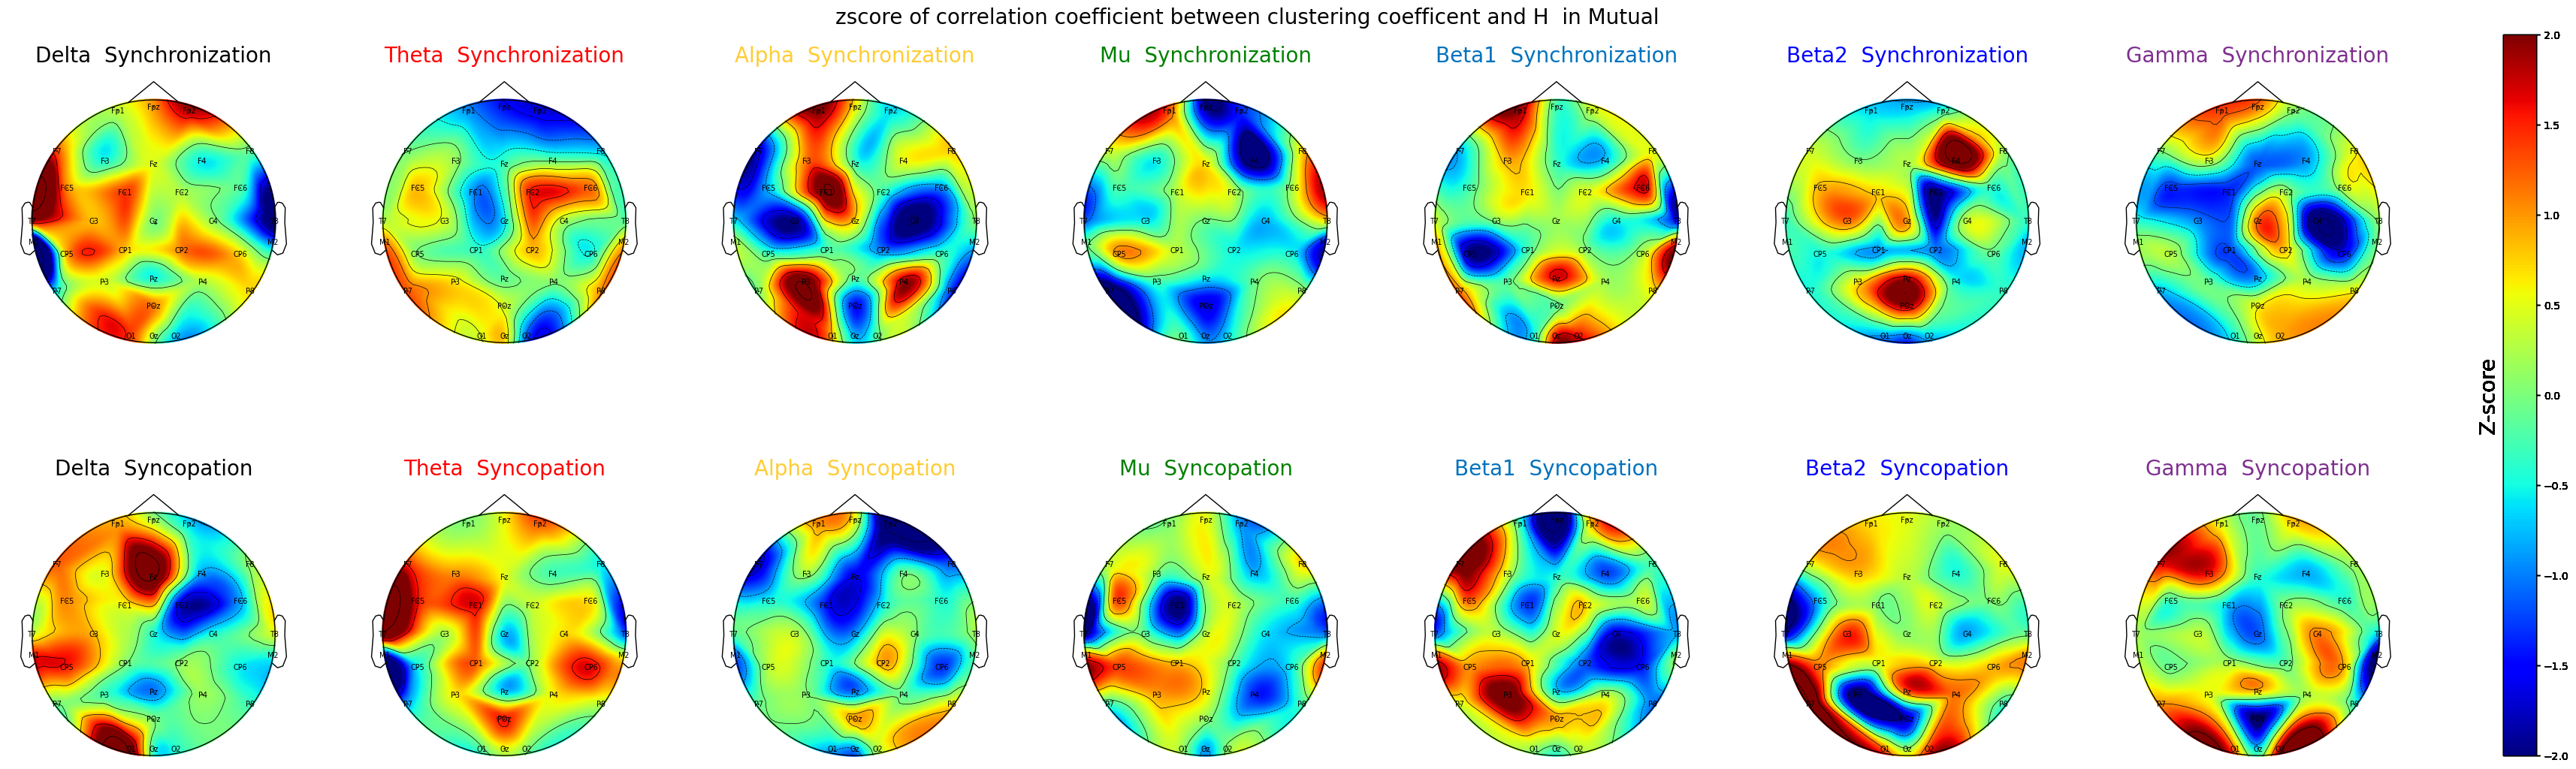

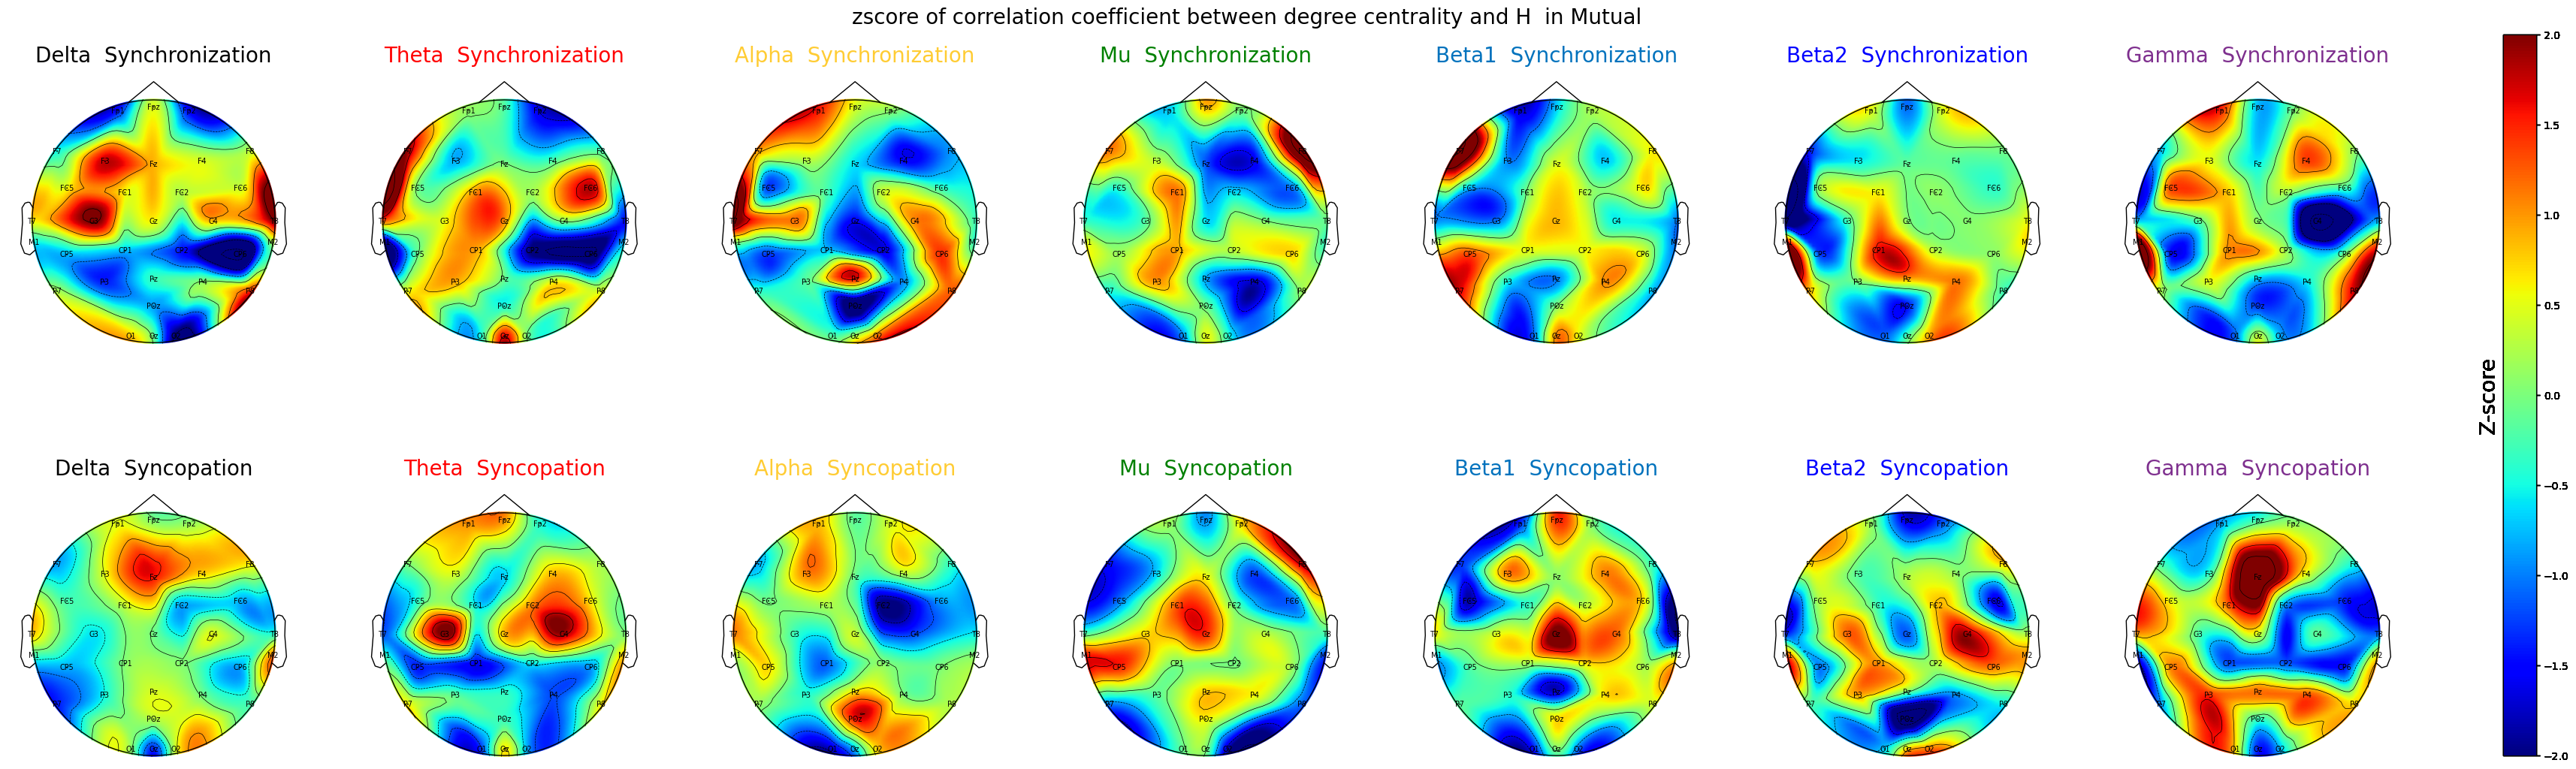

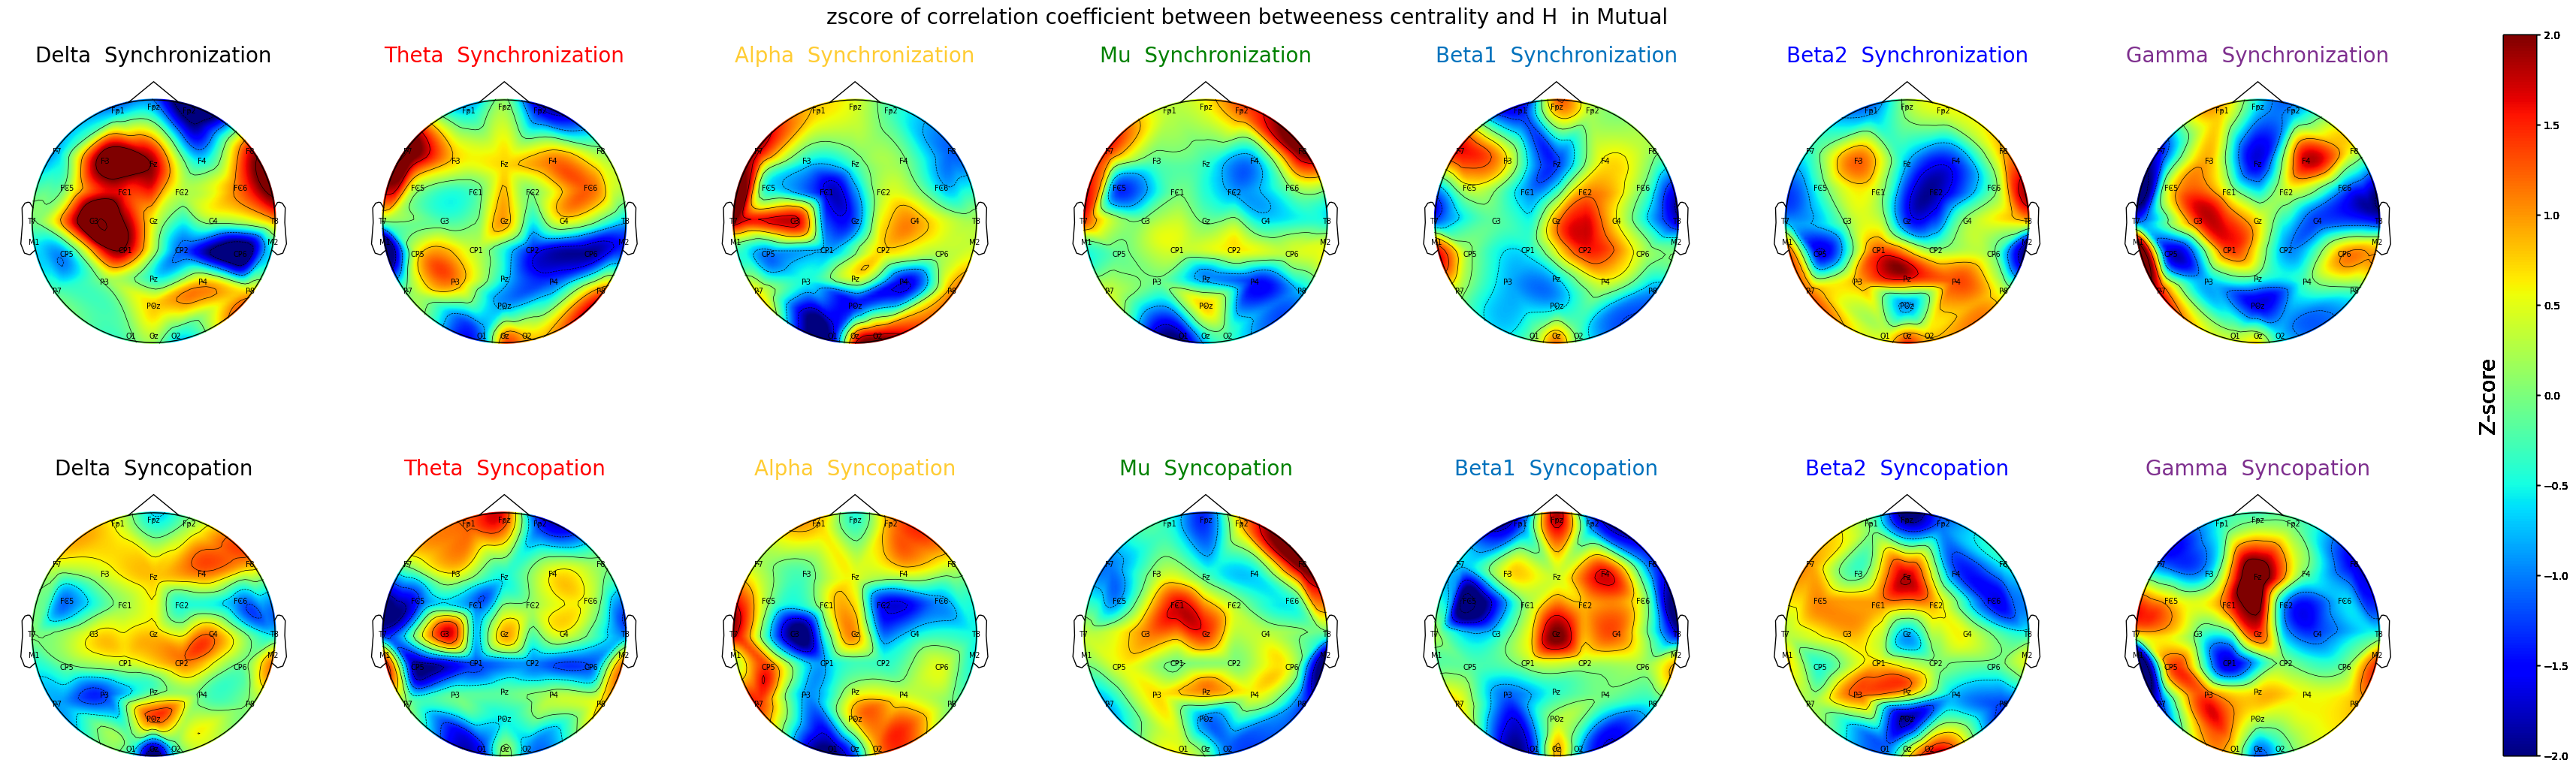

In [140]:
# plot z-score
ctr3names=['clustering coefficent','degree centrality','betweeness centrality']
st=3 # only look at mutual
for ccc in range(3):
    fig, ax = plt.subplots(2,7,figsize=(6*7+2, 6*2))
    for syn in range(2):
        for freq in range(7):
            plt.sca(ax[syn,freq])
            ctr32=np.mean(zscore_crH[ccc,syn,st,:,freq,:],axis=0)
            im,cm = mne.viz.plot_topomap(ctr32,mne_object.info, vlim=(-2, 2), 
                            axes=ax[syn,freq],cmap='jet',show=False,
                            ch_type='eeg', sensors=True, names=labels)
            ax[syn,freq].set_title(band_labels[freq]+'  ' +syn2names[syn],
                    color=freq7colors[freq],
                    fontsize=20)

            fig.subplots_adjust(right=0.85)
            cbar_ax2 = fig.add_axes([0.88, 0.15, 0.01, 0.8])
            cbar_edges=fig.colorbar(im,cbar_ax2)
            cbar_edges.ax.tick_params(labelsize=10)
            cbar_edges.set_label('Z-score',fontsize = 20, rotation=90)
            cbar_edges.ax.yaxis.set_label_position('left')

    plt.suptitle('zscore of correlation coefficient between ' + ctr3names[ccc] + ' and H  in '+states4names[st],
    fontsize=20)


In [7]:
# variable names for plotting
states4names=['Independent','Leading','Following','Mutual']
syn2names=['Synchronization','Syncopation']
states3names=['Independent','Unidirectional','Bidirectional']
band_labels = ['Delta','Theta','Alpha','Mu','Beta1','Beta2','Gamma']

In [8]:
indices=loadmat('Indicies.mat')

# condi4_ind          = outdict['condi4_ind']
# syn_ind             = outdict['syn_ind']
syn2_condi4_ind     = indices['syn2_condi4_ind']
indices.keys()

dict_keys(['L_lead_ind', 'L_lead_synch_ind', 'L_lead_synco_ind', 'Mutual_ind', 'Mutual_synch_ind', 'Mutual_synco_ind', 'R_lead_ind', 'R_lead_synch_ind', 'R_lead_synco_ind', 'Uncoupled_ind', 'Uncoupled_synch_ind', 'Uncoupled_synco_ind', 'condi4_ind', 'syn2_condi4_ind', 'syn_ind', 'synch_condi4_ind', 'synch_ind', 'synco_condi4_ind', 'synco_ind'])

In [9]:
corrdict=loadmat('Corr_eeg144.mat')

eeg_empirical_correlation144x2  = corrdict['eeg_empirical_correlation144x2']     
eeg_partial_correlation144x2    = corrdict['eeg_partial_correlation144x2']       
intervals144                    = corrdict['intervals144']                       
samples144                      = corrdict['samples144']                         
session144                      = corrdict['session144']                         

In [10]:
hurstdict = loadmat('../Hurst_Behav/H.mat')
hurstdict.keys()
H= hurstdict['H']
H.shape

(144, 2)

In [11]:
#organize hurst exponents 
H_follow_synco = np.zeros(36)
H_lead_synco = np.zeros(36)
H_ind_synco = np.zeros(36)
H_mutual_synco = np.zeros(36)
H_follow_synch = np.zeros(36)
H_lead_synch = np.zeros(36)
H_ind_synch = np.zeros(36)
H_mutual_synch = np.zeros(36)

H_follow_synco[0:18] = H[indices['R_lead_synco_ind'],0]
H_follow_synco[18:36] = H[indices['L_lead_synco_ind'],1]
H_lead_synco[0:18] = H[indices['L_lead_synco_ind'],0]
H_lead_synco[18:36] =H[indices['R_lead_synco_ind'],1]
H_mutual_synco[0:18] = H[indices['Mutual_synco_ind'],0] 
H_mutual_synco[18:36] = H[indices['Mutual_synco_ind'],1]
H_ind_synco[0:18] = H[indices['Uncoupled_synco_ind'],0]
H_ind_synco[18:36] = H[indices['Uncoupled_synco_ind'],1]

H_follow_synch[0:18] = H[indices['R_lead_synch_ind'],0]
H_follow_synch[18:36] = H[indices['L_lead_synch_ind'],1]
H_lead_synch[0:18] = H[indices['L_lead_synch_ind'],0]
H_lead_synch[18:36] =H[indices['R_lead_synch_ind'],1]
H_mutual_synch[0:18] = H[indices['Mutual_synch_ind'],0] 
H_mutual_synch[18:36] = H[indices['Mutual_synch_ind'],1]
H_ind_synch[0:18] = H[indices['Uncoupled_synch_ind'],0]
H_ind_synch[18:36] = H[indices['Uncoupled_synch_ind'],1]

In [48]:
# organized into np
H_synch=[H_ind_synch, H_lead_synch, H_follow_synch, H_mutual_synch]
H_synco=[H_ind_synco, H_lead_synco, H_follow_synco, H_mutual_synco]
H_syn=[H_synch, H_synco]

In [12]:
# #organize the correlation matrices

# R_follow_synco = np.zeros((36,7,32,32))
# R_lead_synco = np.zeros((36,7,32,32))
# R_ind_synco = np.zeros((36,7,32,32))
# R_mutual_synco = np.zeros((36,7,32,32))
# R_follow_synch = np.zeros((36,7,32,32))
# R_lead_synch = np.zeros((36,7,32,32))
# R_ind_synch = np.zeros((36,7,32,32))
# R_mutual_synch = np.zeros((36,7,32,32))

# R_follow_synco[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['R_lead_synco_ind'],0,:,:,:]
# R_follow_synco[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['L_lead_synco_ind'],1,:,:,:]
# R_lead_synco[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['L_lead_synco_ind'],0,:,:,:]
# R_lead_synco[18:36,:,:,:] =eeg_empirical_correlation144x2[indices['R_lead_synco_ind'],1,:,:,:]
# R_mutual_synco[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['Mutual_synco_ind'],0,:,:,:] 
# R_mutual_synco[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['Mutual_synco_ind'],1,:,:,:]
# R_ind_synco[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['Uncoupled_synco_ind'],0,:,:,:]
# R_ind_synco[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['Uncoupled_synco_ind'],1,:,:,:]

# R_follow_synch[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['R_lead_synch_ind'],0,:,:,:]
# R_follow_synch[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['L_lead_synch_ind'],1,:,:,:]
# R_lead_synch[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['L_lead_synch_ind'],0,:,:,:]
# R_lead_synch[18:36,:,:,:] =eeg_empirical_correlation144x2[indices['R_lead_synch_ind'],1,:,:,:]
# R_mutual_synch[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['Mutual_synch_ind'],0,:,:,:] 
# R_mutual_synch[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['Mutual_synch_ind'],1,:,:,:]
# R_ind_synch[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['Uncoupled_synch_ind'],0,:,:,:]
# R_ind_synch[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['Uncoupled_synch_ind'],1,:,:,:]


In [13]:
#organize the adjacency matrices from partial correlation
eeg_partial_correlation144x2 = eeg_partial_correlation144x2.astype(bool)
        
A_follow_synco = np.zeros((36,7,32,32))
A_lead_synco = np.zeros((36,7,32,32))
A_ind_synco = np.zeros((36,7,32,32))
A_mutual_synco = np.zeros((36,7,32,32))
A_follow_synch = np.zeros((36,7,32,32))
A_lead_synch = np.zeros((36,7,32,32))
A_ind_synch = np.zeros((36,7,32,32))
A_mutual_synch = np.zeros((36,7,32,32))

A_follow_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['R_lead_synco_ind'],0,:,:,:]
A_follow_synco[18:36,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synco_ind'],1,:,:,:]
A_lead_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synco_ind'],0,:,:,:]
A_lead_synco[18:36,:,:,:] =eeg_partial_correlation144x2[indices['R_lead_synco_ind'],1,:,:,:]
A_mutual_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synco_ind'],0,:,:,:] 
A_mutual_synco[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synco_ind'],1,:,:,:]
A_ind_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synco_ind'],0,:,:,:]
A_ind_synco[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synco_ind'],1,:,:,:]

A_follow_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['R_lead_synch_ind'],0,:,:,:]
A_follow_synch[18:36,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synch_ind'],1,:,:,:]
A_lead_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synch_ind'],0,:,:,:]
A_lead_synch[18:36,:,:,:] =eeg_partial_correlation144x2[indices['R_lead_synch_ind'],1,:,:,:]
A_mutual_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synch_ind'],0,:,:,:] 
A_mutual_synch[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synch_ind'],1,:,:,:]
A_ind_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synch_ind'],0,:,:,:]
A_ind_synch[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synch_ind'],1,:,:,:]

In [47]:
# organized into np
A_synch=[A_ind_synch, A_lead_synch, A_follow_synch, A_mutual_synch]
A_synco=[A_ind_synco, A_lead_synco, A_follow_synco, A_mutual_synco]
A_syn=[A_synch, A_synco]

In [42]:
# r_AH_synco = np.zeros((7,32,32))
# r_AH_synch = np.zeros((7,32,32))
# p_AH_synco = np.zeros((7,32,32))
# p_AH_synch = np.zeros((7,32,32))
# for j in range(7):
#     for k in range(32):
#         for l in range(32):
#             r_AH_synco[j,k,l], p_AH_synco[j,k,l]= pointbiserialr(A_mutual_synco[:,j,k,l],H_mutual_synco)
#             r_AH_synch[j,k,l], p_AH_synch[j,k,l] = pointbiserialr(A_mutual_synch[:,j,k,l],H_mutual_synch)

# # 12s


In [57]:
r_AH=np.zeros((2,4,7,32,32))
p_AH=np.zeros((2,4,7,32,32))
for syn in range(2):
    for st in range(4):
        for freq in range(7):
            for k in range(32):
                for l in range(32):
                    r_AH[syn,st,freq,k,l], p_AH[syn,st,freq,k,l]= pointbiserialr(
                        A_syn[syn][st][:,freq,k,l],H_syn[syn][st])
# 46 s

c:\Users\zhouz\mne-python\1.3.1_0\envs\mne\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Text(0.5, 0.98, 'correlation between pcorr and H  Mutual')

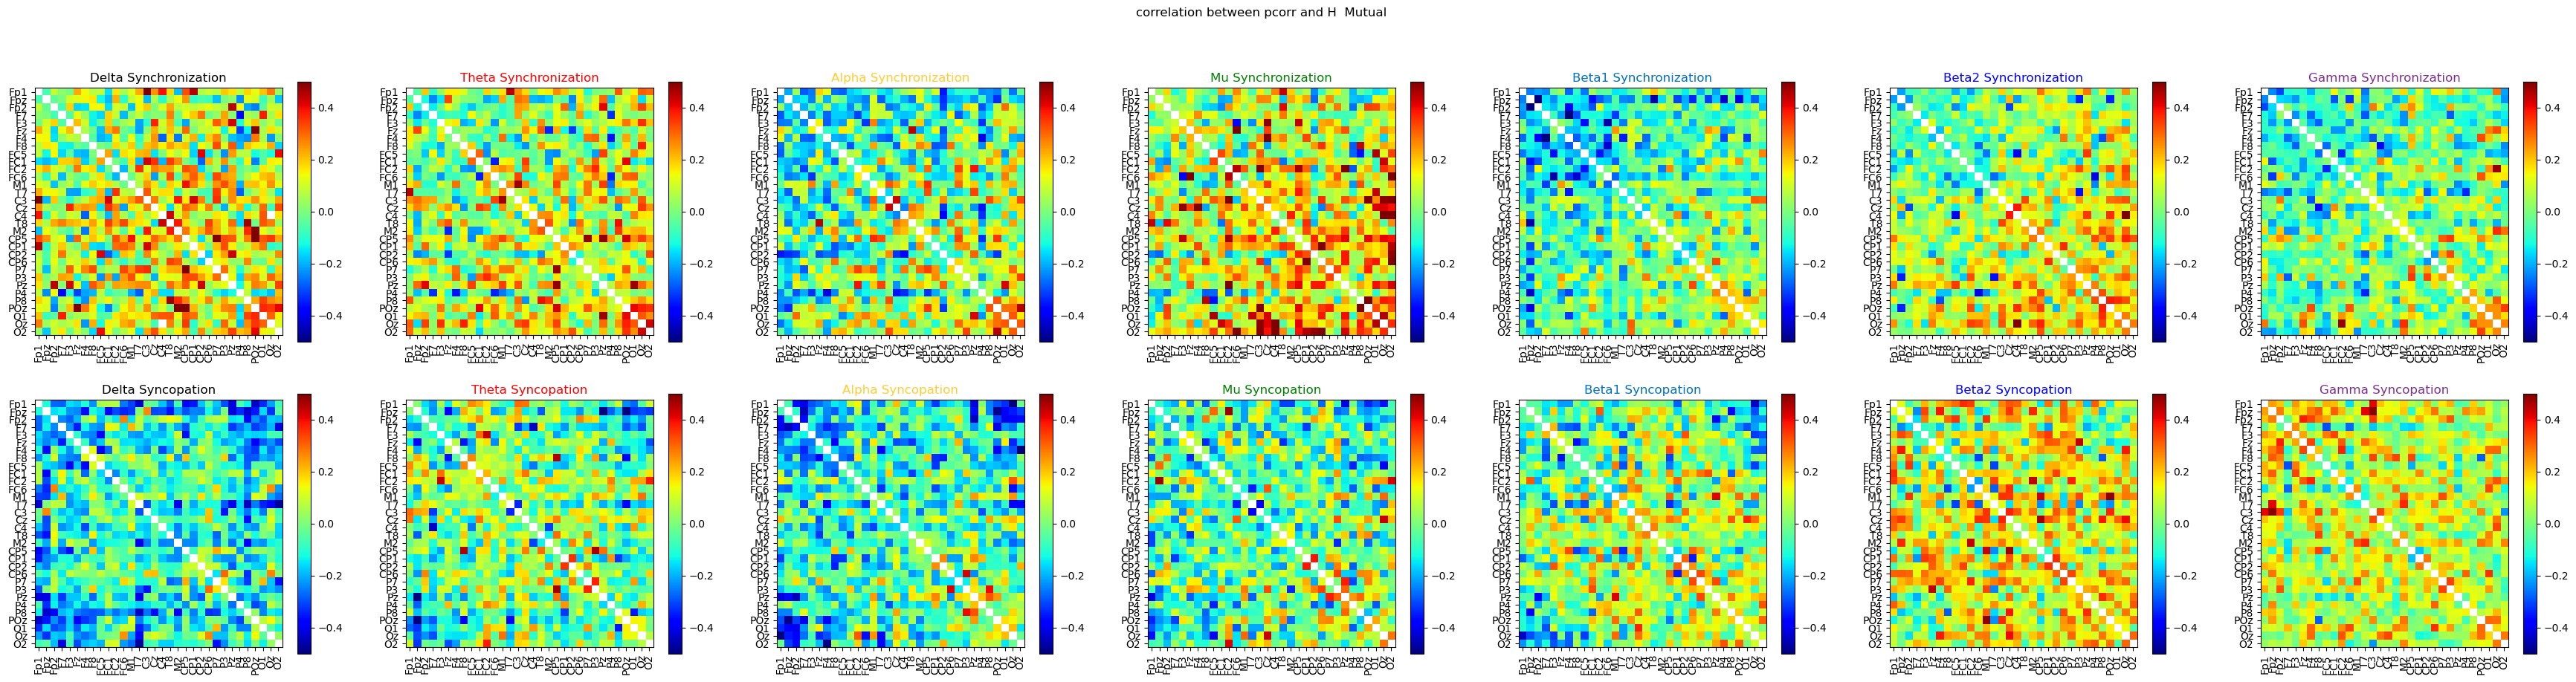

In [95]:
st=3 # only look at mutual
fig, ax = plt.subplots(2,7,figsize=(6*7+2, 5*2))
for syn in range(2):
    for freq in range(7):
        plt.sca(ax[syn,freq])
        data = r_AH[syn,st,freq,:,:]
        title = band_labels[freq]+' '+ syn2names[syn]

        plt.imshow(data,vmin =-0.5,vmax = 0.5, cmap = 'jet')
        plt.colorbar()
        plt.title(title,color=freq7colors[freq])
        plt.xticks(range(32),labels = labels,rotation = 'vertical')
        plt.yticks(range(32),labels = labels,rotation = 'horizontal')

plt.suptitle('correlation between pcorr and H  '+states4names[st])


In [ ]:
# for f in range(7):
#     data = r_AH_synco[f,:,:]
#     title = band_labels[f]+ ' Syncopation'
#     matrixplot(data,title)
#     data = r_AH_synch[f,:,:]
#     title = band_labels[f]+ ' Synchronization'
#     matrixplot(data,title)

    

In [63]:
# compute centrality
cc3_syn=np.zeros((3,2,4,36,7,32))
for syn in range(2):
    for freq in range(7):
        for tr in range(36):
            G=nx.from_numpy_array(A_syn[syn][st][tr,freq,:,:])
            x0=nx.clustering(G)
            x1=nx.degree_centrality(G)
            x2=nx.betweenness_centrality(G)
            del(G)
            for chan in range(32):
                cc3_syn[0,syn,st,tr,freq,chan]=x0[chan]
                cc3_syn[1,syn,st,tr,freq,chan]=x1[chan]
                cc3_syn[2,syn,st,tr,freq,chan]=x2[chan]
# 2.5s
            

In [30]:
# f=5
# G_lead_synco = dict()
# G_follow_synco = dict()
# G_ind_synco = dict()
# G_mutual_synco = dict()

# c_lead_synco = np.zeros((36,32))
# c_follow_synco = np.zeros((36,32))
# c_ind_synco = np.zeros((36,32))
# c_mutual_synco = np.zeros((36,32))

# d_lead_synco = np.zeros((36,32))
# d_follow_synco = np.zeros((36,32))
# d_ind_synco = np.zeros((36,32))
# d_mutual_synco = np.zeros((36,32))


# G_lead_synch = dict()
# G_follow_synch = dict()
# G_ind_synch = dict()
# G_mutual_synch = dict()

# c_lead_synch = np.zeros((36,32))
# c_follow_synch = np.zeros((36,32))
# c_ind_synch = np.zeros((36,32))
# c_mutual_synch = np.zeros((36,32))

# d_lead_synch = np.zeros((36,32))
# d_follow_synch = np.zeros((36,32))
# d_ind_synch = np.zeros((36,32))
# d_mutual_synch = np.zeros((36,32))

# for j in range(36):
# 	G_lead_synco[j] = nx.from_numpy_array(A_lead_synco[j,f,:,:])
# 	x = nx.clustering(G_lead_synco[j])
# 	xd = nx.degree_centrality(G_lead_synco[j])
# 	G_follow_synco[j] = nx.from_numpy_array(A_follow_synco[j,f,:,:])
# 	y = nx.clustering(G_follow_synco[j])
# 	yd = nx.degree_centrality(G_follow_synco[j])
# 	G_ind_synco[j] = nx.from_numpy_array(A_ind_synco[j,f,:,:])
# 	z = nx.clustering(G_ind_synco[j])
# 	zd = nx.degree_centrality(G_ind_synco[j])
# 	G_mutual_synco[j] = nx.from_numpy_array(A_mutual_synco[j,f,:,:])
# 	w = nx.clustering(G_mutual_synco[j])
# 	wd = nx.degree_centrality(G_mutual_synco[j])
# 	for k in range(32):
# 		c_lead_synco[j,k] = x[k]
# 		c_follow_synco[j,k] = y[k]
# 		c_ind_synco[j,k] = z[k]
# 		c_mutual_synco[j,k] = w[k]
# 		d_lead_synco[j,k] = xd[k]
# 		d_follow_synco[j,k] = yd[k]
# 		d_ind_synco[j,k] = zd[k]
# 		d_mutual_synco[j,k] = wd[k]

# #dc_ind = (dc_lead+dc_ind)/2


# for j in range(36):
# 	G_lead_synch[j] = nx.from_numpy_array(A_lead_synch[j,f,:,:])
# 	x = nx.clustering(G_lead_synch[j])
# 	xd = nx.degree_centrality(G_lead_synch[j])
# 	G_follow_synch[j] = nx.from_numpy_array(A_follow_synch[j,f,:,:])
# 	y = nx.clustering(G_follow_synch[j])
# 	yd = nx.degree_centrality(G_follow_synch[j])
# 	G_ind_synch[j] = nx.from_numpy_array(A_ind_synch[j,f,:,:])
# 	z = nx.clustering(G_ind_synch[j])
# 	zd = nx.degree_centrality(G_ind_synch[j])
# 	G_mutual_synch[j] = nx.from_numpy_array(A_mutual_synch[j,f,:,:])
# 	w = nx.clustering(G_mutual_synch[j])
# 	wd = nx.degree_centrality(G_mutual_synch[j])
	
# 	for k in range(32):
# 		c_lead_synch[j,k] = x[k]
# 		c_follow_synch[j,k] = y[k]
# 		c_ind_synch[j,k] = z[k]
# 		c_mutual_synch[j,k] = w[k]
# 		d_lead_synch[j,k] = xd[k]
# 		d_follow_synch[j,k] = yd[k]
# 		d_ind_synch[j,k] = zd[k]
# 		d_mutual_synch[j,k] = wd[k]

# #dc_ind = (dc_lead+dc_ind)/2





In [73]:
# correlation
r_ccH=np.zeros((3,2,4,7,32))
p_ccH=np.zeros((3,2,4,7,32))
for ccc in range(3):
    for syn in range(2):
        for st in range(4):
            for freq in range(7):
                for chan in range(32):
                    r_ccH[ccc,syn,st,freq,chan],p_ccH[ccc,syn,st,freq,chan]= pearsonr(
                        cc3_syn[ccc,syn,st,:,freq,chan],H_syn[syn][st])

c:\Users\zhouz\mne-python\1.3.1_0\envs\mne\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Text(0.5, 1.0, 'Beta2')

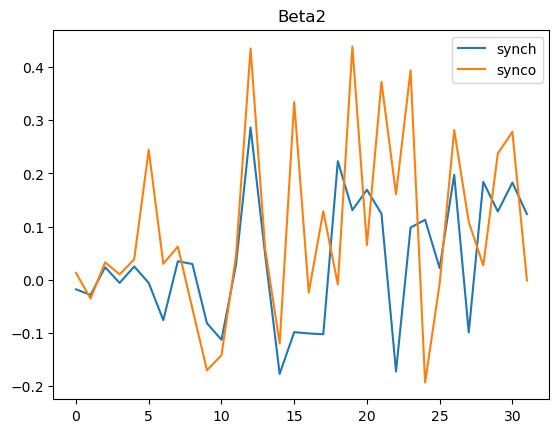

In [78]:
ccc=0; st=3; freq=5
plt.plot(r_ccH[ccc,0,st,freq,:])
plt.plot(r_ccH[ccc,1,st,freq,:])
plt.legend(('synch','synco'))
plt.title(band_labels[freq])

In [ ]:
# from scipy.stats import pearsonr
# x0 = np.zeros(32)
# x1 = np.zeros(32)
# p0 = np.zeros(32)
# p1 = np.zeros(32)
# for j in range(32):
#     x0[j],p0[j] = pearsonr(c_mutual_synch[:,j],H_mutual_synch)
#     x1[j],p1[j] = pearsonr(c_mutual_synco[:,j],H_mutual_synco)
# plt.plot(x0)
# plt.plot(x1)
# plt.legend(('synch','synco'))
# plt.title(band_labels[f])
# print(p0)
# print(p1)